# Develop exposure analysis


In [1]:
%matplotlib inline
from importlib import reload
import glob
from astropy.io import fits
from astropy.coordinates import SkyCoord
import exposure as exp; reload(exp)
from timed_data import MJD

### Locate files used for catalog
Note that the data files are not FT1 but binned: code here uses only for GTI data

In [2]:
yearly_ft2files = sorted(glob.glob('/nfs/farm/g/glast/g/catalog/P8_P305/ft2_20*.fits'))
yearly_datafiles= sorted(glob.glob(os.path.expandvars('$FERMI/data/P8_P305/yearly/*.fits')))
# select  a year: note that year 0 is 5 months
year_index=1
ft2= yearly_ft2files[year_index]
ft1= yearly_datafiles[year_index]

### Create LiveTime object using FT2 and GTI from the data files

In [3]:
lt = exp.Livetime(ft2, ft1, )

Processing GTI...
Processed 1 GTI files wtth 6215 intervals with 26,456,181 s live time
Loading FT2 files ['ft2_2009.fits']
Processing the FT2 file (calculating overlap with GTI)...


### Get timed info from a source
Need its name, position, and times

In [4]:
data_file =  '../data/vela.pkl'
data_rec = pd.read_pickle(data_file);

source_name= data_rec['name']
l,b = data_rec['galactic']
etime = data_rec['time_data'].time
print(f'Loaded data for source "{source_name}" at l,b=({l:.3f},{b:.3f}) from file {data_file}')
print(f'   {len(etime):,} photons from MET {etime[0]:.0f} to {etime[-1]:.0f}')

Loaded data for source "vela pulsar" at l,b=(263.552,-2.787) from file ../data/vela.pkl
   3,950,346 photons from MET 239562775 to 573335078


### Use the LiveTime object to determine the exposure history at that position

In [5]:
edf = lt.get_exposure(SkyCoord.from_name(source_name)) # the exposure data frame
tstart=edf.tstart.values
tstop =edf.tstop.values

# find range comvered by current GTI and make subset DataFrame
imin,imax = np.searchsorted(etime, [tstart[0],tstop[-1]]);
setime = etime[imin:imax]
print(f'Select {len(setime):,} photons within live time range')

# get associated live time index for each photon
lt_index = np.searchsorted(tstop, setime) # before which stop
# make sure past start
tdiff = setime - tstart[lt_index]
in_gti = tdiff>=0
print(f'... and exclude {sum(~in_gti):,} photons not in GTI')
etime_ok = setime[in_gti] 

Exposure time range: 252485968 to 284034493
Select 357,926 photons within live time range
... and exclude 2,731 photons not in GTI


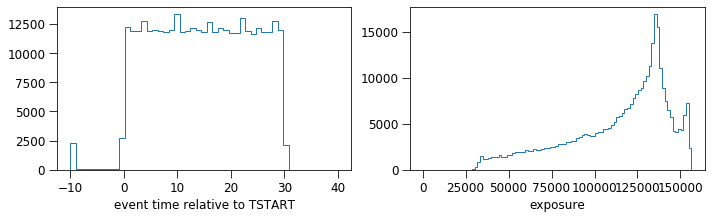

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(12,3))
ax1.hist(tdiff.clip(-10, 40), np.linspace(-10,40), histtype='step')
ax1.set(xlabel='event time relative to TSTART')

# check that LT intervals found have sensible livetime
ax2.hist(edf.exposure[lt_index], bins=100, histtype='step');
ax2.set(xlabel='exposure');

### Check integrated exposure vs. time

In [7]:
cexposure = np.concatenate(([0],np.cumsum(edf.exposure.values*(edf.tstop.values-edf.tstart.values))))

day = 24*3600
delta_t =  2*day # days
time_range = tstop[-1]-tstart[0]
nbins = int(time_range/delta_t)+1; print(f'Selecting {nbins} intervals of {delta_t/day} days')
bin_edge = tstart[0] + np.arange(nbins+1)*delta_t 
bin_center = (bin_edge[1:]+bin_edge[:-1])/2
# get index into tstop array of the bin edges
edge_index = np.searchsorted(tstop, bin_edge)
# now the exposure integrated over the intervals
bin_exp  =  np.diff(cexposure[edge_index])

Selecting 183 intervals of 2.0 days


### Compare with actual Vela measured rate

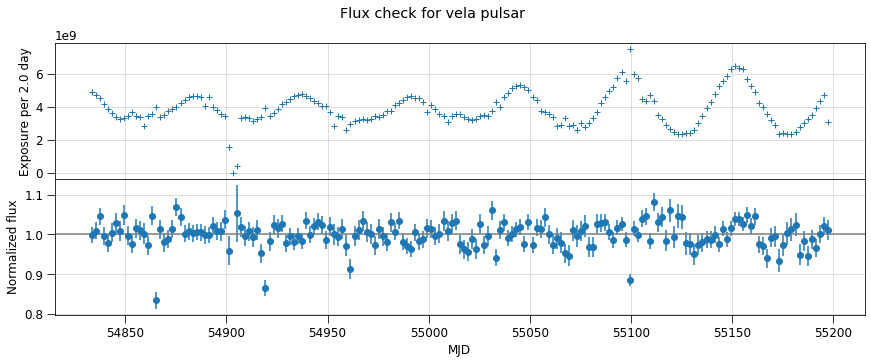

In [11]:
binned_data = np.histogram(etime_ok, bin_edge)[0]
mask = binned_data>100
ratio = binned_data[mask]/bin_exp[mask]
y = ratio/ratio.mean()
fig, (ax1,ax2)= plt.subplots(2,1, figsize=(15,5), sharex=True,gridspec_kw=dict(hspace=0) )
t = MJD(bin_center)
ax1.plot(t, bin_exp, '+'); ax1.grid(alpha=0.5)
ax1.set(ylabel=f'Exposure per {delta_t/day} day')
dy = y/np.sqrt(binned_data[mask]) 
ax2.errorbar(x =  t[mask],   y=y, yerr=dy,  fmt='o');
ax2.set(xlabel='MJD', ylabel='Normalized flux')
ax2.axhline(1, color='grey');ax2.grid(alpha=0.5)
fig.suptitle(f'Flux check for {source_name}');